In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv


In [93]:
import sklearn
import scipy.sparse 
from itertools import product
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [3]:
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [4]:
def downcast_dtypes(df):
    
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [50]:
def rmse(*args):
    
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))

In [51]:
def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)

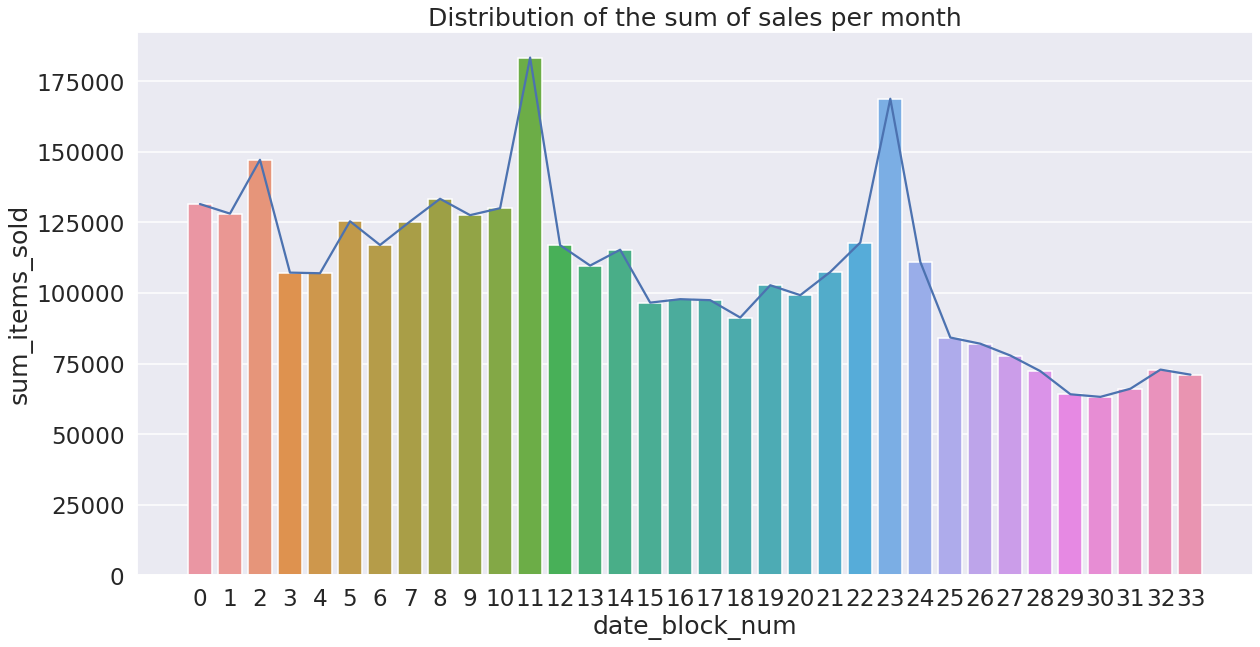

In [5]:
sns.set_context("talk", font_scale=1.4)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Sum of sales per month')
del sales_month

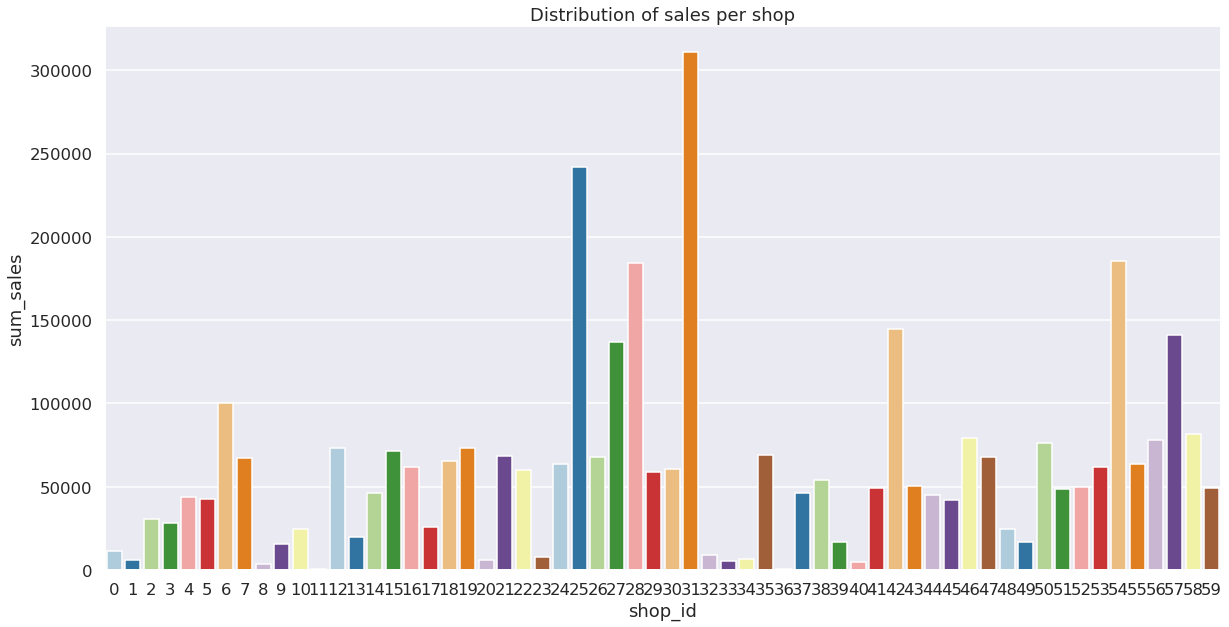

In [7]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

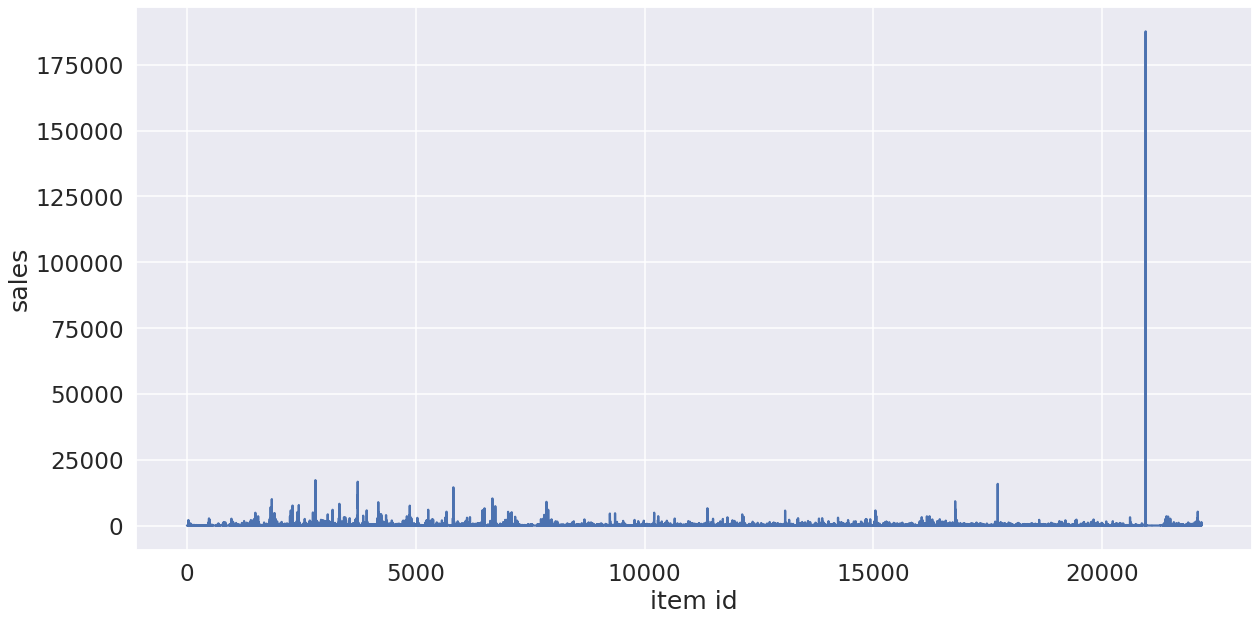

In [8]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id)

In [9]:
anomaly_item = sales_item_id.item_cnt_day.argmax()
anomaly_item

20602

In [11]:
tuples_df = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(tuples_df.isin(tuples_test).sum()/len(tuples_df),2)*100)+'%')

42.0%


In [33]:
def get_feature_matrix(sales, test, items, list_lags, date_block_threshold):
  
    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Add submission shop_id-item_id in order to test predictions
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={'item_cnt_day': 'target'})
    
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={'item_cnt_day':'target_item'})
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

In [34]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = sales[sales.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_for_modelling, test, items, list_lags, date_block_threshold)

Index(['shop_id', 'item_id', 'date_block_num', 'target'], dtype='object')
Index(['shop_id', 'date_block_num', 'target_shop'], dtype='object')
Index(['item_id', 'date_block_num', 'target_item'], dtype='object')


In [36]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


In [38]:
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281,2.742767
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868,10.631319
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281,2.742767
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868,10.631319
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726,2.715576


In [39]:
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
sub_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459


In [80]:
dates = all_data['date_block_num']
boolean_test = (dates.isin([31,32,33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [81]:
print('X_train shape is ' + str(X_train.shape))
print('X_val shape is ' + str(X_val.shape))

X_train shape is (2536620, 12)
X_val shape is (573954, 12)


In [82]:
print(f'Cross-validation is the {round(X_val.shape[0]/X_train.shape[0],2)*100} %' )

Cross-validation is the 23.0 %


In [83]:
tuples_validation_submission = pd.Series(list(X_val[['item_id', 'shop_id']][dates_val==33].itertuples(index=False, name=None)))
print(f'The {round(tuples_test.isin(tuples_validation_submission).sum()/len(tuples_test),2)*100} % of the item_id-shop_id are in the cv set ')

The 93.0 % of the item_id-shop_id are in the cv set 


In [99]:
X = X_train.append(X_val)
y = np.concatenate([y_train, y_val])

In [101]:
rf = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [103]:
rf.fit(X, clip40(y))

RandomForestRegressor(bootstrap=0.7, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [104]:
pred_rf_val = clip20(rf.predict(X_val.fillna(0)))
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), pred_rf_val))

Train RMSE for rf is 0.953483
Val RMSE for rf is 0.845839


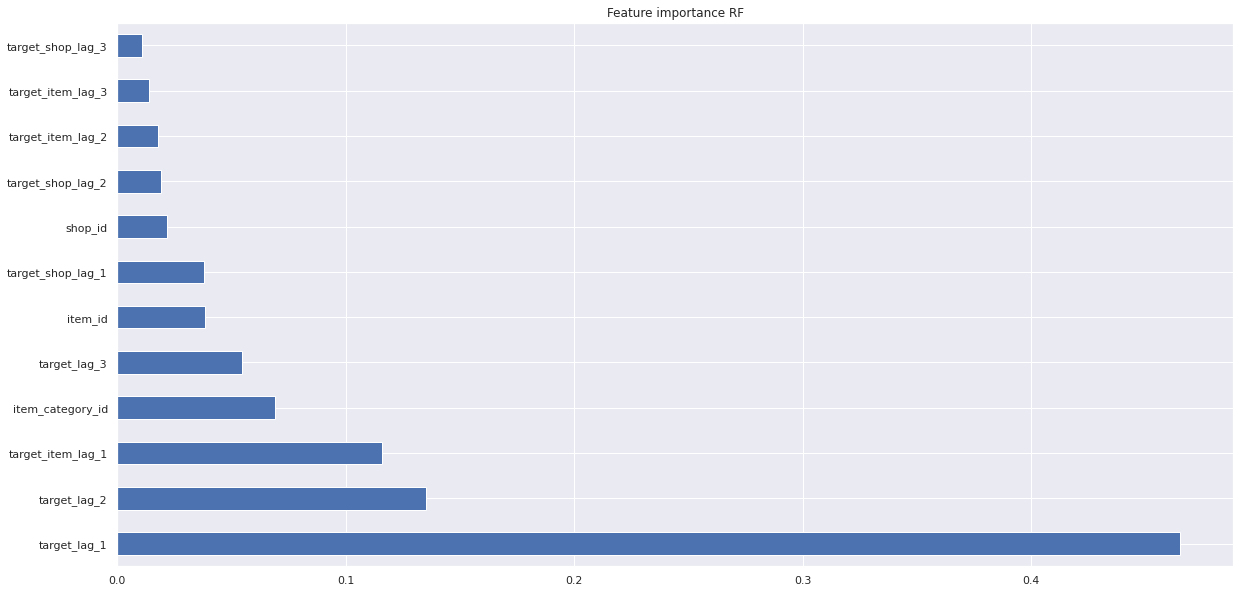

In [110]:
feat_importances = pd.Series(rf.feature_importances_, index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance RF')
plt.show()

In [114]:
test_pred = rf.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))

In [117]:
os.unlink('submission.csv')

In [120]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('submission.csv',index=False)